In [1]:
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score,hamming_loss, precision_score, recall_score, f1_score,accuracy_score
import re
from collections import Counter
import seaborn as sns
import warnings
import os
import string
import time
warnings.filterwarnings('ignore')

In [2]:
import cupy as cp

class ActivationFunction:
    class Sigmoid:
        def forward(self, x):
            return 1 / (1 + cp.exp(-x))
        def derivative(self, x):
            s = self.forward(x)
            return s * (1 - s)
    
    class Tanh:
        def forward(self, x):
            return cp.tanh(x)
        def derivative(self, x):
            return 1 - cp.square(cp.tanh(x))
    
    class ReLU:
        def forward(self, x):
            return cp.maximum(0, x)
        def derivative(self, x):
            return cp.where(x > 0, 1.0, 0.0)

class Layer:
    def __init__(self, input_size, output_size, activation):
        self.weights = cp.random.randn(output_size, input_size) * cp.sqrt(2 / input_size)
        self.biases = cp.zeros((output_size, 1))
        self.activation = activation
        self.dw = None
        self.db = None
    
    def forward(self, x):
        self.a_prev = x
        self.z = cp.dot(self.weights, x) + self.biases
        self.a = self.activation.forward(self.z)
        return self.a
    
    def backward(self, grad):
        delta = grad * self.activation.derivative(self.z)
        self.dw = cp.dot(delta, self.a_prev.T)
        self.db = cp.sum(delta, axis=1, keepdims=True)
        grad_prev = cp.dot(self.weights.T, delta)
        return grad_prev

class Optimizer:
    class SGD:
        def __init__(self, learning_rate):
            self.learning_rate = learning_rate
        
        def update(self, layers):
            for layer in layers:
                layer.weights -= self.learning_rate * layer.dw
                layer.biases -= self.learning_rate * layer.db
    
    class BatchGradientDescent:
        def __init__(self, learning_rate):
            self.learning_rate = learning_rate
        
        def update(self, layers):
            for layer in layers:
                layer.weights -= self.learning_rate * layer.dw
                layer.biases -= self.learning_rate * layer.db
    
    class MiniBatchGradientDescent:
        def __init__(self, learning_rate, batch_size):
            self.learning_rate = learning_rate
            self.batch_size = batch_size
        
        def update(self, layers):
            for layer in layers:
                layer.weights -= self.learning_rate * layer.dw
                layer.biases -= self.learning_rate * layer.db

class LossFunction:
    class BinaryCrossEntropy:
        def compute(self, y_true, y_pred):
            epsilon = 1e-8
            return -cp.mean(y_true * cp.log(y_pred + epsilon) + (1 - y_true) * cp.log(1 - y_pred + epsilon))

        def derivative(self, y_true, y_pred):
            epsilon = 1e-8
            return -((y_true / (y_pred + epsilon)) - ((1 - y_true) / (1 - y_pred + epsilon)))

class DataLoader:
    def __init__(self, X, y, batch_size):
        self.X = cp.array(X)
        self.y = cp.array(y)
        self.batch_size = batch_size
        self.n_samples = self.X.shape[0]
    
    def get_batch(self):
        indices = cp.arange(self.n_samples)
        cp.random.shuffle(indices)
        for i in range(0, self.n_samples, self.batch_size):
            batch_indices = indices[i:i+self.batch_size]
            yield self.X[batch_indices], self.y[batch_indices]
    
    def get_full_batch(self):
        return self.X, self.y

class MultiLabelMLP:
    def __init__(self, layer_sizes, hidden_activation='relu', optimizer_type='mini_batch', learning_rate=0.01, batch_size=32):
        self.layers = []
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        activation_map = {
            'sigmoid': ActivationFunction.Sigmoid(),
            'tanh': ActivationFunction.Tanh(),
            'relu': ActivationFunction.ReLU()
        }
        
        hidden_act = activation_map[hidden_activation]
        output_act = ActivationFunction.Sigmoid()
        
        for i in range(len(layer_sizes)-2):
            self.layers.append(Layer(layer_sizes[i], layer_sizes[i+1], hidden_act))
        
        self.layers.append(Layer(layer_sizes[-2], layer_sizes[-1], output_act))
        
        if optimizer_type == 'sgd':
            self.optimizer = Optimizer.SGD(learning_rate)
            self.batch_size = 1
            self.use_full_batch = False
        elif optimizer_type == 'batch':
            self.optimizer = Optimizer.BatchGradientDescent(learning_rate)
            self.use_full_batch = True
        elif optimizer_type == 'mini_batch':
            self.optimizer = Optimizer.MiniBatchGradientDescent(learning_rate, batch_size)
            self.use_full_batch = False
        
        self.loss_history = []
        self.val_loss_history = []
    
    def forward(self, x):
        a = x
        for layer in self.layers:
            a = layer.forward(a)
        return a
    
    def backward(self, y_true, y_pred):
        grad = LossFunction.BinaryCrossEntropy().derivative(y_true, y_pred)
        
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100):
        data_loader = DataLoader(X_train, y_train, self.batch_size)
        
        for epoch in range(epochs):
            epoch_losses = []
            
            if self.use_full_batch:
                X_batch, y_batch = data_loader.get_full_batch()
                y_pred = self.forward(X_batch.T)
                loss = LossFunction.BinaryCrossEntropy().compute(y_batch.T, y_pred)
                epoch_losses.append(float(loss))
                self.backward(y_batch.T, y_pred)
                self.optimizer.update(self.layers)
            else:
                for X_batch, y_batch in data_loader.get_batch():
                    y_pred = self.forward(X_batch.T)
                    loss = LossFunction.BinaryCrossEntropy().compute(y_batch.T, y_pred)
                    epoch_losses.append(float(loss))
                    self.backward(y_batch.T, y_pred)
                    self.optimizer.update(self.layers)
            
            avg_loss = float(cp.mean(cp.array(epoch_losses)))  # Convert CuPy scalar to Python float
            self.loss_history.append(avg_loss)

            
            if X_val is not None and y_val is not None:
                val_pred = self.forward(cp.array(X_val).T)
                val_loss = LossFunction.BinaryCrossEntropy().compute(cp.array(y_val).T, val_pred)
                self.val_loss_history.append(float(val_loss))
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.4f}", end="")
                if X_val is not None:
                    print(f", Val Loss: {float(val_loss):.4f}")
                else:
                    print()
    
    def predict(self, X):
        return self.forward(cp.array(X).T).T
    
    def predict_classes(self, X, threshold=0.5):
        y_pred = self.predict(X)
        return (y_pred >= threshold).astype(int)


In [3]:
import cupy as cp
import pandas as pd
import re
from collections import Counter
from sklearn.model_selection import train_test_split

print("Loading data...")

# Load the CSV files
train_data = pd.read_csv('/kaggle/input/ques2-3-dataset/train.csv')
test_data = pd.read_csv('/kaggle/input/ques2-3-dataset/test.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Clean and preprocess text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

print("Preprocessing text...")
train_data['clean_document'] = train_data['document'].apply(clean_text)
test_data['clean_document'] = test_data['document'].apply(clean_text)

# Process labels
def get_labels(category_string):
    if isinstance(category_string, str):
        return [label.strip() for label in category_string.split(',')]
    return []

train_data['labels'] = train_data['category'].apply(get_labels)
test_data['labels'] = test_data['category'].apply(get_labels)

# Get unique labels
all_labels = set()
for labels in train_data['labels']:
    all_labels.update(labels)
label_list = sorted(list(all_labels))

# Create label binary matrix
def create_label_matrix(data, label_list):
    label_matrix = cp.zeros((len(data), len(label_list)))
    for i, labels in enumerate(data['labels']):
        for label in labels:
            if label in label_list:
                label_matrix[i, label_list.index(label)] = 1
    return label_matrix

train_labels_matrix = create_label_matrix(train_data, label_list)
test_labels_matrix = create_label_matrix(test_data, label_list)

# TF-IDF Feature Extraction
def tokenize(text):
    return text.split()

def compute_tf_idf(documents, max_features=5000):
    tokenized_docs = [tokenize(doc) for doc in documents]
    doc_freq = Counter()
    for doc in tokenized_docs:
        unique_terms = set(doc)
        for term in unique_terms:
            doc_freq[term] += 1
    
    vocab = [term for term, count in doc_freq.most_common(max_features)]
    vocab_to_idx = {term: idx for idx, term in enumerate(vocab)}
    
    n_docs = len(documents)
    tf_matrix = cp.zeros((n_docs, len(vocab)))
    
    for doc_idx, doc in enumerate(tokenized_docs):
        doc_length = len(doc)
        term_freq = Counter(doc)
        
        for term, freq in term_freq.items():
            if term in vocab_to_idx:
                tf = freq / doc_length
                term_idx = vocab_to_idx[term]
                tf_matrix[doc_idx, term_idx] = tf
    
    idf_values = cp.log(n_docs / (cp.array([doc_freq[term] + 1 for term in vocab])) + 1)
    tf_idf_matrix = tf_matrix * idf_values
    return tf_idf_matrix, vocab_to_idx

tf_idf_train, vocab_to_idx = compute_tf_idf(train_data['clean_document'], max_features=5000)

def transform_new_docs(documents, vocab_to_idx):
    tokenized_docs = [tokenize(doc) for doc in documents]
    n_docs = len(documents)
    tf_matrix = cp.zeros((n_docs, len(vocab_to_idx)))
    
    for doc_idx, doc in enumerate(tokenized_docs):
        doc_length = len(doc)
        term_freq = Counter(doc)
        
        for term, freq in term_freq.items():
            if term in vocab_to_idx:
                tf = freq / doc_length
                term_idx = vocab_to_idx[term]
                tf_matrix[doc_idx, term_idx] = tf
    
    n_docs_train = tf_idf_train.shape[0]
    idf_values = cp.log(n_docs_train / (cp.sum(tf_idf_train > 0, axis=0) + 1)) + 1
    tf_idf_matrix = tf_matrix * idf_values
    return tf_idf_matrix

tf_idf_test = transform_new_docs(test_data['clean_document'], vocab_to_idx)

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    tf_idf_train, train_labels_matrix, test_size=0.2, random_state=42
)

# Evaluation Metrics
def hamming_loss(y_true, y_pred):
    return cp.mean(cp.abs(y_true - y_pred))

def accuracy_score(y_true, y_pred):
    correct = cp.sum(cp.all(y_true == y_pred, axis=1))
    return correct / y_true.shape[0]

def precision_score(y_true, y_pred):
    true_positives = cp.sum(cp.logical_and(y_pred == 1, y_true == 1))
    predicted_positives = cp.sum(y_pred == 1)
    return true_positives / predicted_positives if predicted_positives > 0 else 0

def recall_score(y_true, y_pred):
    true_positives = cp.sum(cp.logical_and(y_pred == 1, y_true == 1))
    actual_positives = cp.sum(y_true == 1)
    return true_positives / actual_positives if actual_positives > 0 else 0

def f1_score(y_true, y_pred):
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

def evaluate_model(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred >= threshold).astype(cp.int32)
    metrics = {
        'Hamming Loss': hamming_loss(y_true, y_pred_binary),
        'Accuracy': accuracy_score(y_true, y_pred_binary),
        'Precision': precision_score(y_true, y_pred_binary),
        'Recall': recall_score(y_true, y_pred_binary),
        'F1 Score': f1_score(y_true, y_pred_binary)
    }
    return metrics


Loading data...
Training data shape: (7769, 2)
Test data shape: (3019, 2)
Preprocessing text...


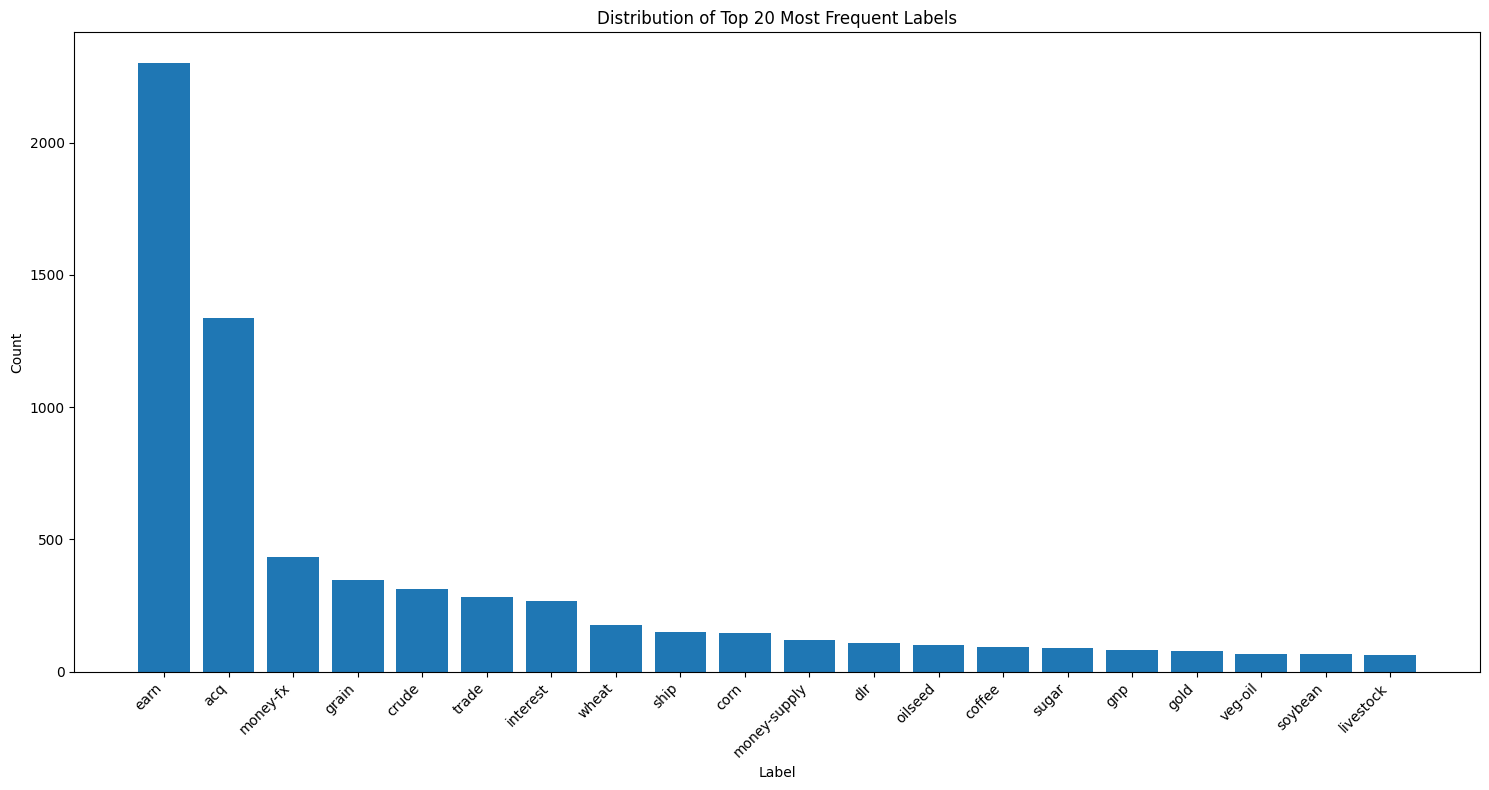

Total number of labels: 90
Average labels per document: 1.23
Most common label: earn (2302.0 occurrences)
Least common label: castor-oil (1.0 occurrences)
Input size (features): 5000
Output size (labels): 90


In [4]:
# 5. Experimental Setup and Training

# Function to run experiments with different hyperparameters
def run_experiments(X_train, y_train, X_val, y_val, X_test, y_test, input_size, output_size):
    # Configurations to test
    hidden_activations = ['relu', 'tanh']
    optimizers = ['mini_batch', 'batch', 'sgd']
    learning_rates = [0.01, 0.001]
    architectures = [
        [input_size, 128, output_size],
        [input_size, 128, 64, output_size]
    ]
    batch_size=32
    epochs = [20,30]
    
    results = []
    
    for hidden_activation in hidden_activations:
        for optimizer_type in optimizers:
            for learning_rate in learning_rates:
                for architecture in architectures:
                    for epoch in epochs:
                        print(f"\nTraining with: Activation={hidden_activation}, Optimizer={optimizer_type}, "
                              f"LR={learning_rate}, Architecture={architecture}, Batch Size={batch_size}")
                        
                        # Initialize model
                        model = MultiLabelMLP(
                            layer_sizes=architecture,
                            hidden_activation=hidden_activation,
                            optimizer_type=optimizer_type,
                            learning_rate=learning_rate,
                            batch_size=batch_size
                        )
                        
                        # Train model
                        start_time = time.time()
                        model.train(X_train, y_train, X_val, y_val, epochs=epoch)
                        training_time = time.time() - start_time
                        
                        # Evaluate on validation set
                        val_predictions = model.predict(X_val)
                        val_metrics = evaluate_model(y_val, val_predictions)
                        
                        # Evaluate on test set
                        test_predictions = model.predict(X_test)
                        test_metrics = evaluate_model(y_test, test_predictions)
                        
                        # Store results
                        experiment_result = {
                            'activation': hidden_activation,
                            'optimizer': optimizer_type,
                            'learning_rate': learning_rate,
                            'architecture': architecture,
                            'batch_size': batch_size,
                            'training_time': training_time,
                            'val_metrics': val_metrics,
                            'test_metrics': test_metrics,
                            'train_loss_history': model.loss_history,
                            'val_loss_history': model.val_loss_history
                        }
                        results.append(experiment_result)
                        
                        # Plot training curves
                        plt.figure(figsize=(10, 5))
                        plt.plot(model.loss_history, label='Training Loss')
                        plt.plot(model.val_loss_history, label='Validation Loss')
                        plt.xlabel('Epoch')
                        plt.ylabel('Loss')
                        plt.title(f'Loss Curves: {hidden_activation} + {optimizer_type} (LR={learning_rate})')
                        plt.legend()
                        plt.grid(True)
                        plt.show()

                        print("--"*20)
                        print("\n")
    
    return results



# 7. Function for presenting results
def display_results(results):
    print("\n======= RESULTS =======")
    
    # Sort results by test F1 score
    sorted_results = sorted(results, key=lambda x: x['test_metrics']['F1 Score'], reverse=True)
    
    for i, result in enumerate(sorted_results):
        if 'config' in result:  # For demo mode
            config = result['config']
            print(f"\nRank {i+1}: {config['activation']} + {config['optimizer']} (LR={config['lr']})")
        else:  # For full experiment mode
            print(f"\nRank {i+1}: {result['activation']} + {result['optimizer']} (LR={result['learning_rate']})")
        
        print(f"Architecture: {result['architecture'] if 'architecture' in result else result['config']['arch']}")
        print(f"Batch Size: {result['batch_size'] if 'batch_size' in result else result['config']['batch_size']}")
        print(f"Training Time: {result['training_time']:.2f} seconds")
        
        print("\nTest Metrics:")
        for metric, value in result['test_metrics'].items():
            print(f"  {metric}: {value:.4f}")
    
    # Identify best configuration
    best_result = sorted_results[0]
    print("\n===== BEST CONFIGURATION =====")
    if 'config' in best_result:  # For demo mode
        best_config = best_result['config']
        print(f"Activation: {best_config['activation']}")
        print(f"Optimizer: {best_config['optimizer']}")
        print(f"Learning Rate: {best_config['lr']}")
        print(f"Architecture: {best_config['arch']}")
        print(f"Batch Size: {best_config['batch_size']}")
    else:  # For full experiment mode
        print(f"Activation: {best_result['activation']}")
        print(f"Optimizer: {best_result['optimizer']}")
        print(f"Learning Rate: {best_result['learning_rate']}")
        print(f"Architecture: {best_result['architecture']}")
        print(f"Batch Size: {best_result['batch_size']}")
    
    print("\nBest Test Metrics:")
    for metric, value in best_result['test_metrics'].items():
        print(f"  {metric}: {value:.4f}")

# 8. Visualize class distribution
def visualize_label_distribution(y_train):
    label_counts = np.sum(y_train, axis=0)
    
    # Sort labels by frequency
    sorted_indices = np.argsort(label_counts)[::-1]
    sorted_counts = label_counts[sorted_indices]
    sorted_labels = [label_list[i] for i in sorted_indices]
    
    # Plot top 20 most frequent labels
    plt.figure(figsize=(15, 8))
    plt.bar(range(min(20, len(sorted_labels))), sorted_counts[:20])
    plt.xticks(range(min(20, len(sorted_labels))), sorted_labels[:20], rotation=45, ha='right')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Top 20 Most Frequent Labels')
    plt.tight_layout()
    plt.show()
    
    # Print label statistics
    print(f"Total number of labels: {len(label_list)}")
    print(f"Average labels per document: {np.mean(np.sum(y_train, axis=1)):.2f}")
    print(f"Most common label: {label_list[np.argmax(label_counts)]} ({np.max(label_counts)} occurrences)")
    print(f"Least common label: {label_list[np.argmin(label_counts)]} ({np.min(label_counts)} occurrences)")


# Convert data to CuPy arrays
X_train_cp = cp.asarray(X_train)
y_train_cp = cp.asarray(y_train)
X_val_cp = cp.asarray(X_val)
y_val_cp = cp.asarray(y_val)
X_test_cp = cp.asarray(tf_idf_test)
y_test_cp = cp.asarray(test_labels_matrix)

# Display label distribution
visualize_label_distribution(y_train_cp.get())  # Convert back to NumPy for visualization

# Get input and output sizes
input_size = X_train_cp.shape[1]
output_size = y_train_cp.shape[1]

print(f"Input size (features): {input_size}")
print(f"Output size (labels): {output_size}")



    


Training with: Activation=relu, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0249, Val Loss: 0.0250
Epoch 20/20, Train Loss: 0.0170, Val Loss: 0.0179


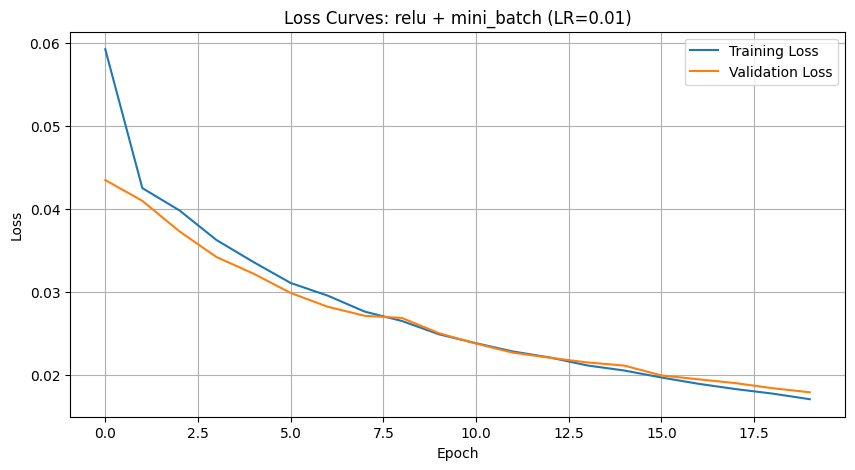

----------------------------------------



Training with: Activation=relu, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0248, Val Loss: 0.0242
Epoch 20/30, Train Loss: 0.0167, Val Loss: 0.0179
Epoch 30/30, Train Loss: 0.0126, Val Loss: 0.0148


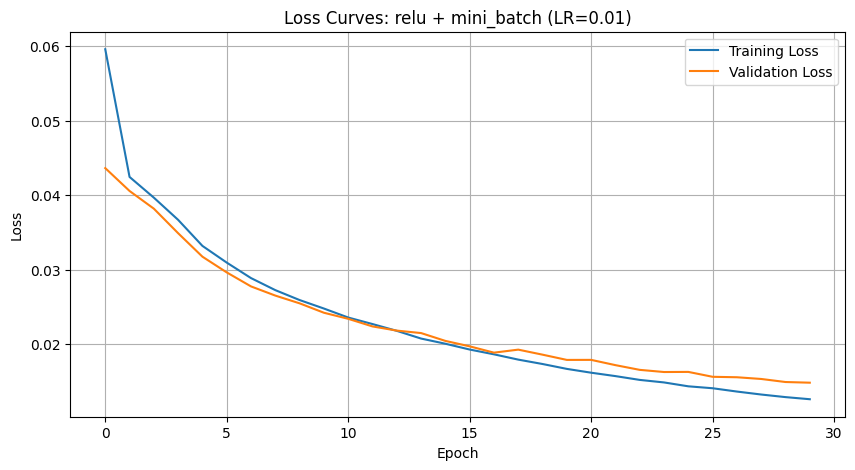

----------------------------------------



Training with: Activation=relu, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0216, Val Loss: 0.0224
Epoch 20/20, Train Loss: 0.0136, Val Loss: 0.0147


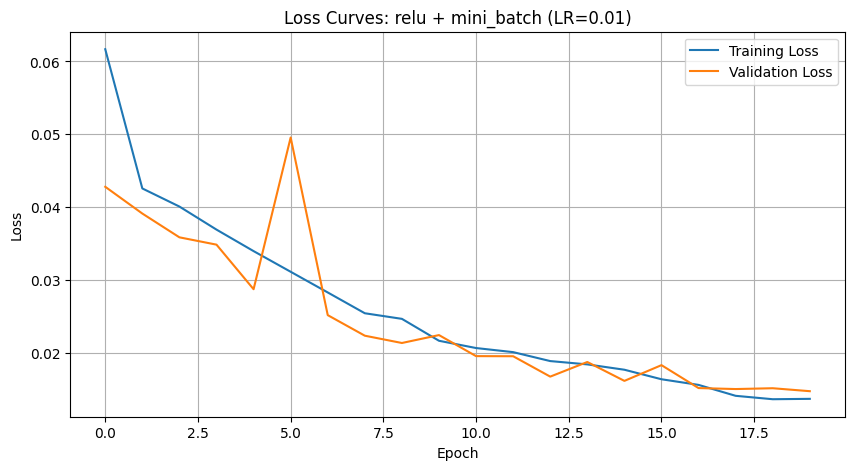

----------------------------------------



Training with: Activation=relu, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0243, Val Loss: 0.0227
Epoch 20/30, Train Loss: 0.0138, Val Loss: 0.0138
Epoch 30/30, Train Loss: 0.0091, Val Loss: 0.0124


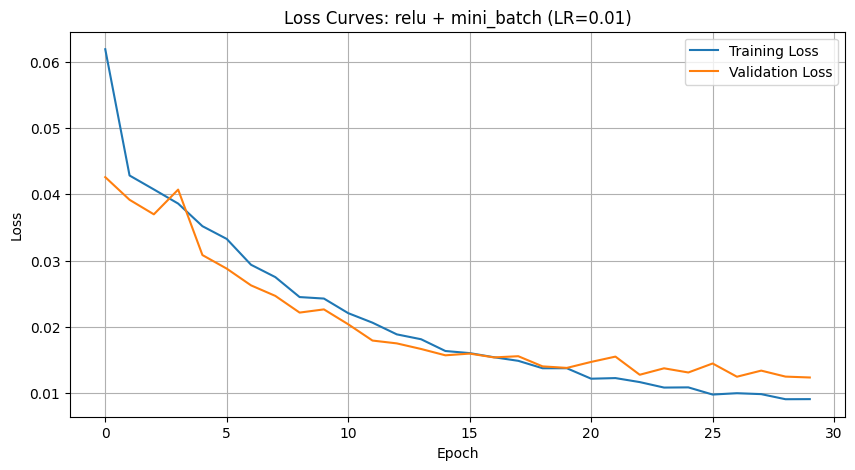

----------------------------------------



Training with: Activation=relu, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0430, Val Loss: 0.0425
Epoch 20/20, Train Loss: 0.0393, Val Loss: 0.0392


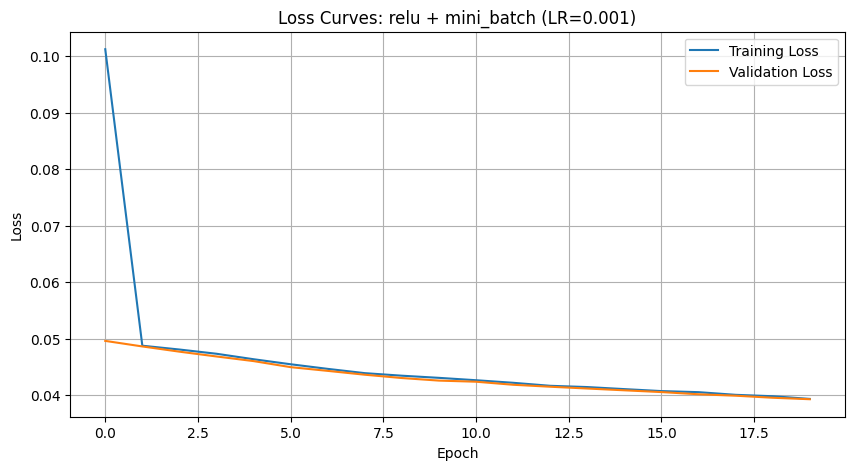

----------------------------------------



Training with: Activation=relu, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0430, Val Loss: 0.0427
Epoch 20/30, Train Loss: 0.0392, Val Loss: 0.0389
Epoch 30/30, Train Loss: 0.0356, Val Loss: 0.0354


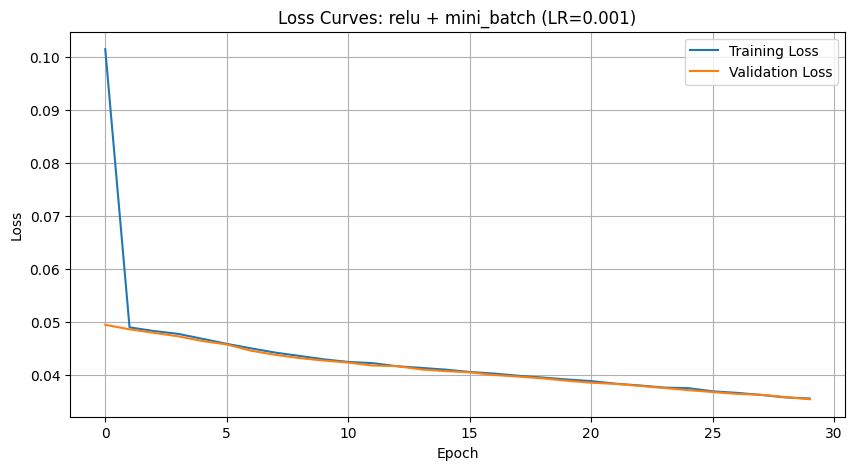

----------------------------------------



Training with: Activation=relu, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0389, Val Loss: 0.0382
Epoch 20/20, Train Loss: 0.0304, Val Loss: 0.0304


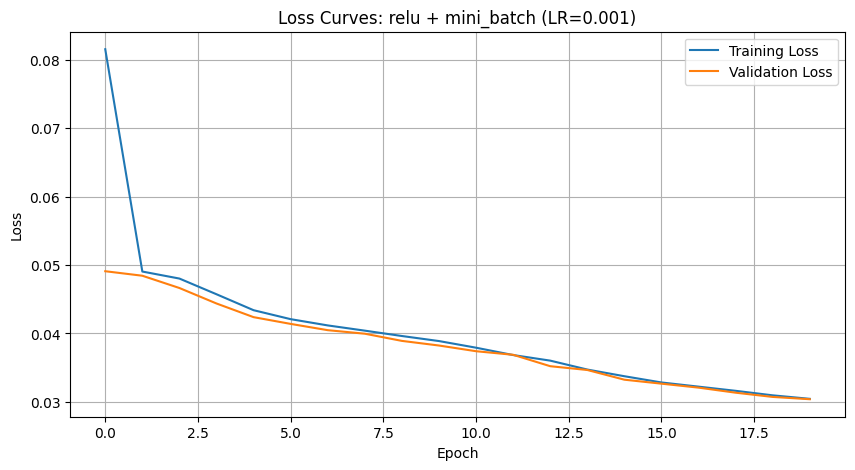

----------------------------------------



Training with: Activation=relu, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0394, Val Loss: 0.0387
Epoch 20/30, Train Loss: 0.0307, Val Loss: 0.0308
Epoch 30/30, Train Loss: 0.0255, Val Loss: 0.0263


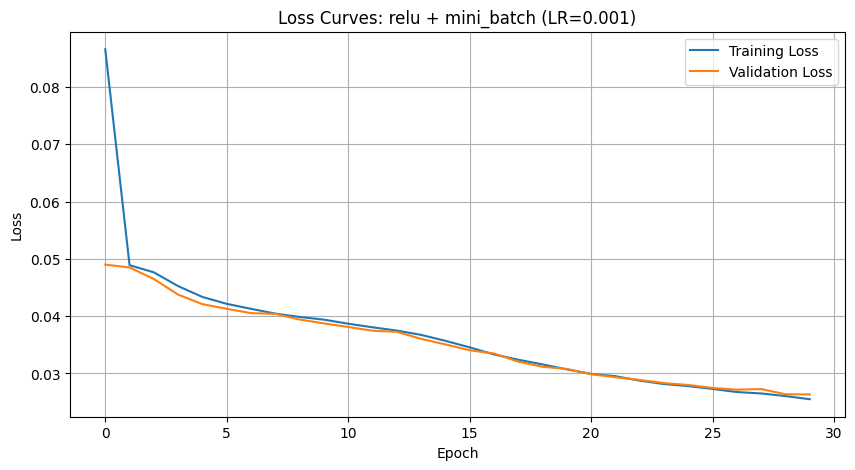

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 20/20, Train Loss: 0.2526, Val Loss: 0.2520


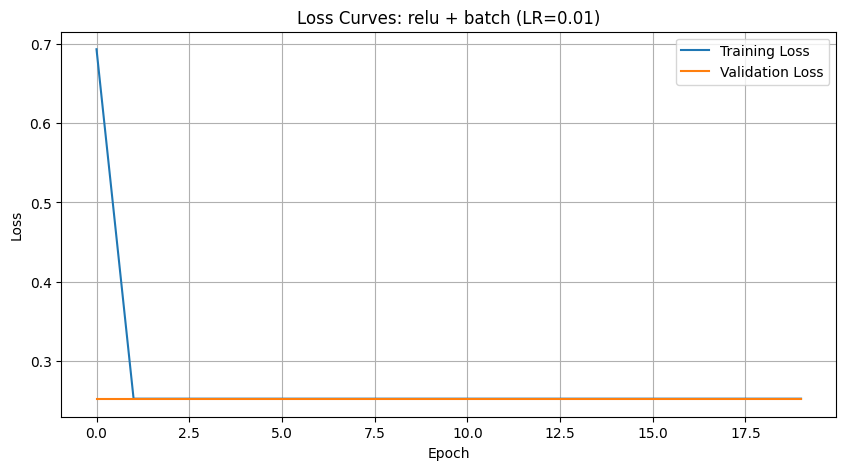

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 20/30, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 30/30, Train Loss: 0.2526, Val Loss: 0.2520


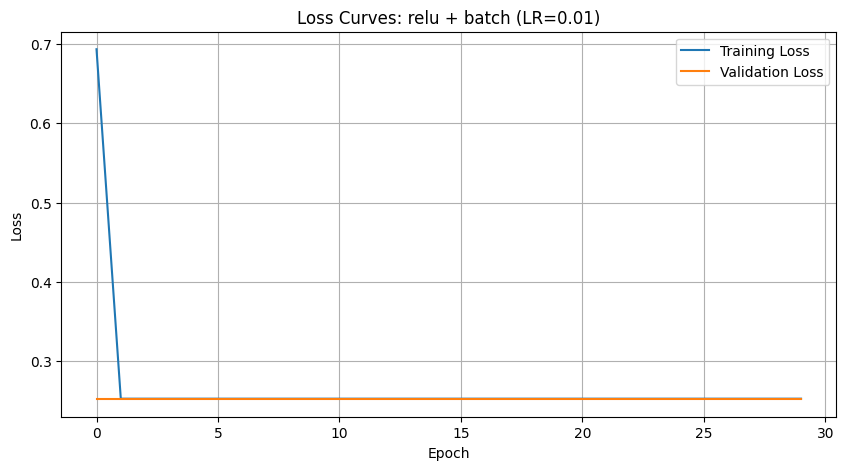

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 20/20, Train Loss: 0.2526, Val Loss: 0.2520


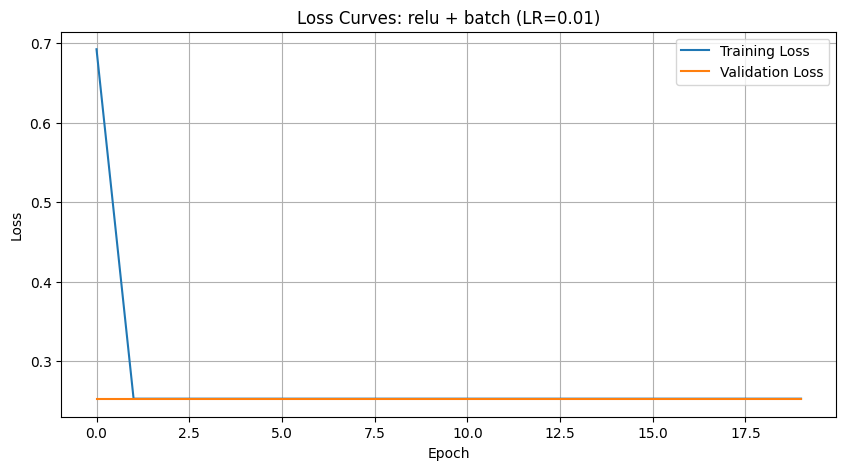

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 20/30, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 30/30, Train Loss: 0.2526, Val Loss: 0.2520


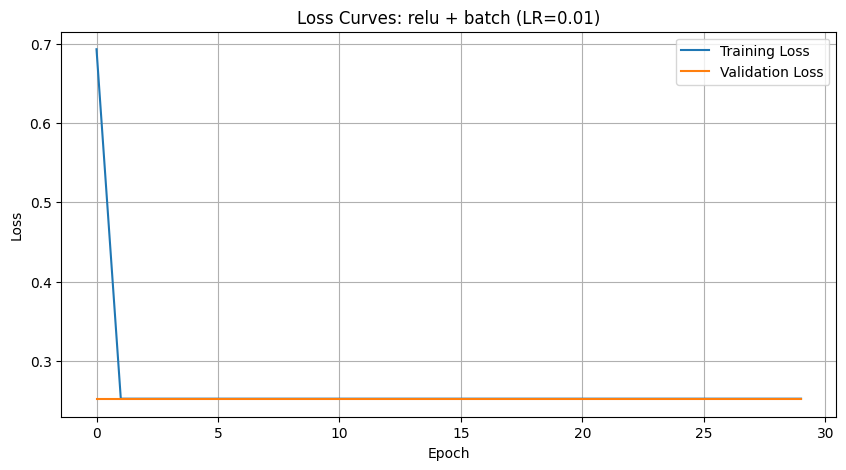

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0666, Val Loss: 0.0656
Epoch 20/20, Train Loss: 0.0563, Val Loss: 0.0566


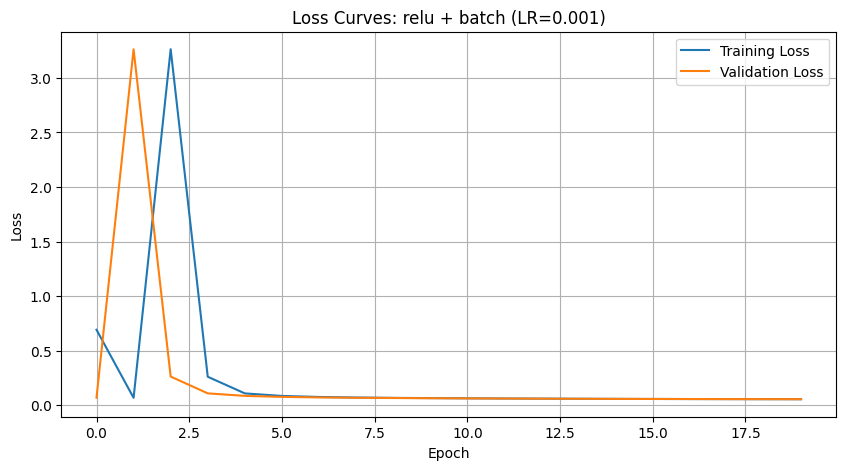

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0673, Val Loss: 0.0650
Epoch 20/30, Train Loss: 0.0553, Val Loss: 0.0547
Epoch 30/30, Train Loss: 0.0525, Val Loss: 0.0522


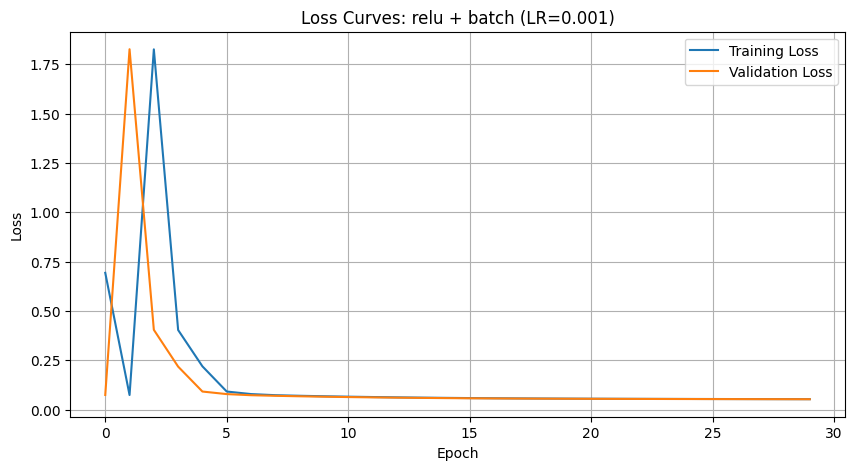

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0664, Val Loss: 0.0631
Epoch 20/20, Train Loss: 0.0583, Val Loss: 0.0614


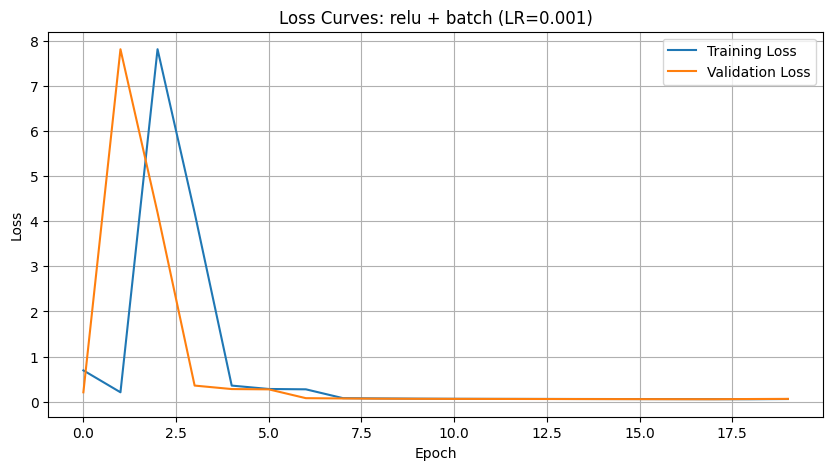

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.2834, Val Loss: 0.2786
Epoch 20/30, Train Loss: 0.0634, Val Loss: 0.0628
Epoch 30/30, Train Loss: 0.0564, Val Loss: 0.0563


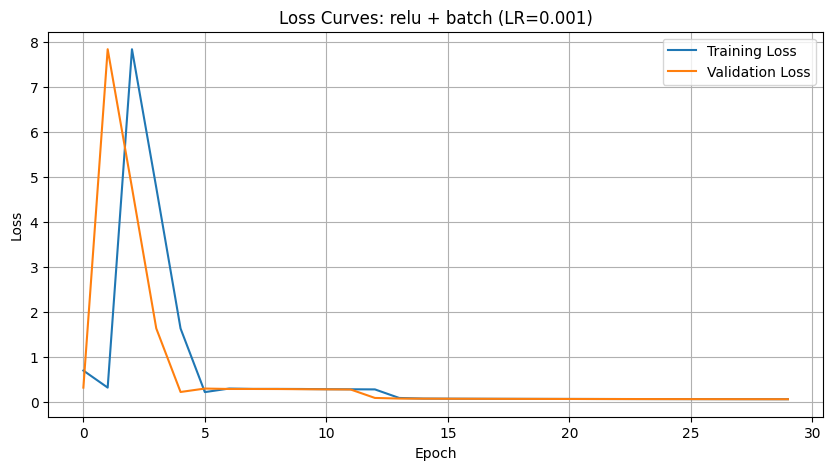

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0242, Val Loss: 0.0242
Epoch 20/20, Train Loss: 0.0165, Val Loss: 0.0175


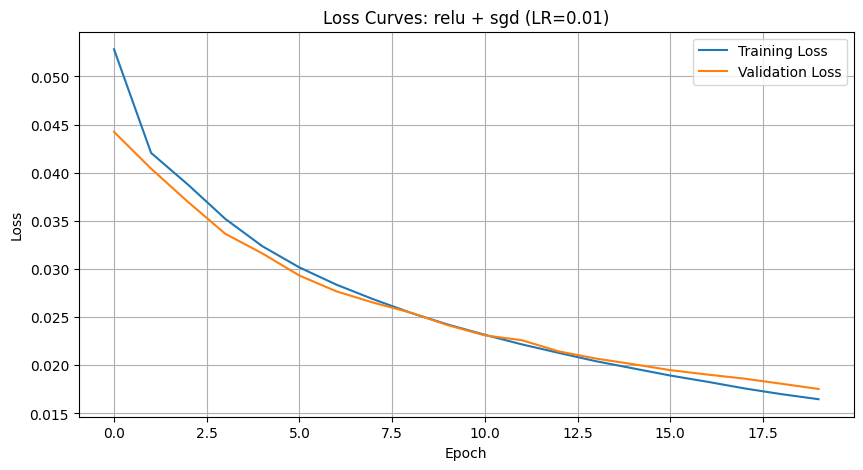

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0244, Val Loss: 0.0243
Epoch 20/30, Train Loss: 0.0165, Val Loss: 0.0177
Epoch 30/30, Train Loss: 0.0124, Val Loss: 0.0149


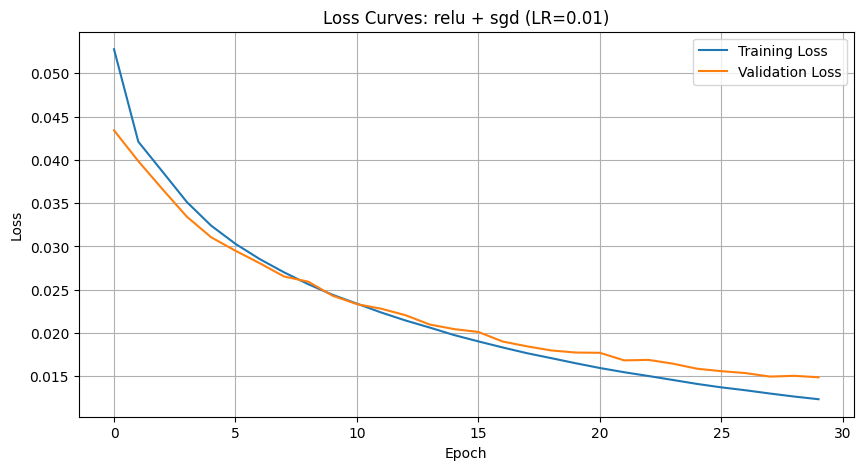

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0150, Val Loss: 0.0178
Epoch 20/20, Train Loss: 0.0083, Val Loss: 0.0132


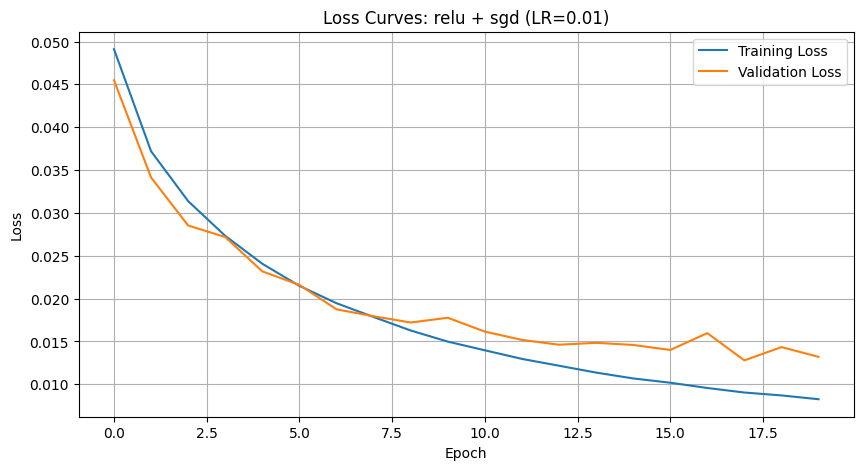

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0150, Val Loss: 0.0161
Epoch 20/30, Train Loss: 0.0083, Val Loss: 0.0126
Epoch 30/30, Train Loss: 0.0054, Val Loss: 0.0122


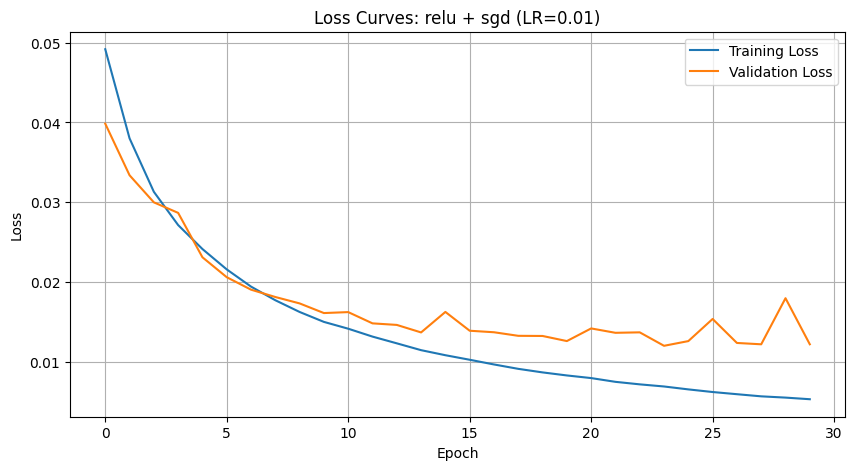

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0429, Val Loss: 0.0425
Epoch 20/20, Train Loss: 0.0392, Val Loss: 0.0391


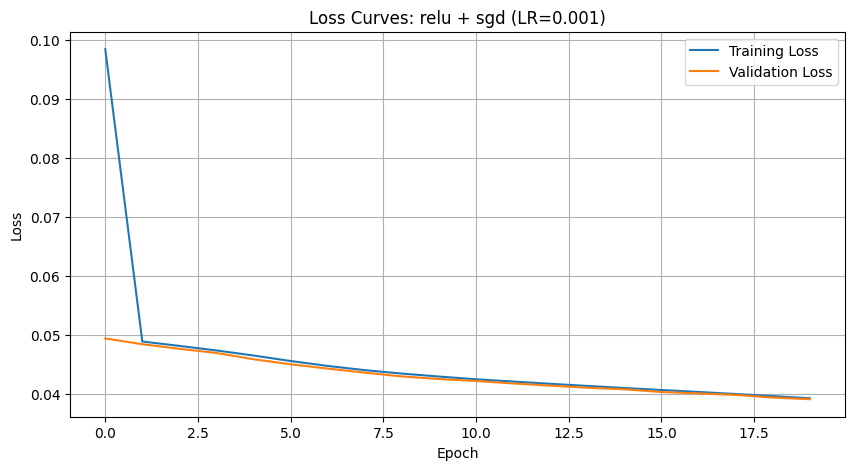

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0429, Val Loss: 0.0426
Epoch 20/30, Train Loss: 0.0394, Val Loss: 0.0393
Epoch 30/30, Train Loss: 0.0357, Val Loss: 0.0356


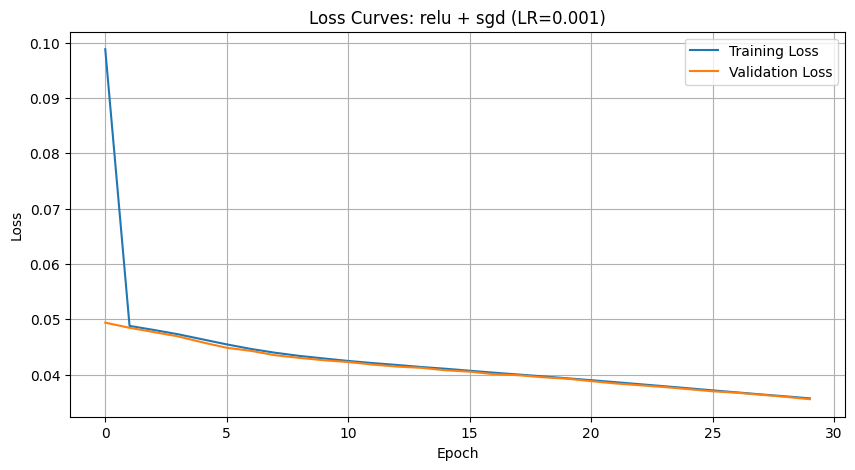

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0389, Val Loss: 0.0386
Epoch 20/20, Train Loss: 0.0302, Val Loss: 0.0301


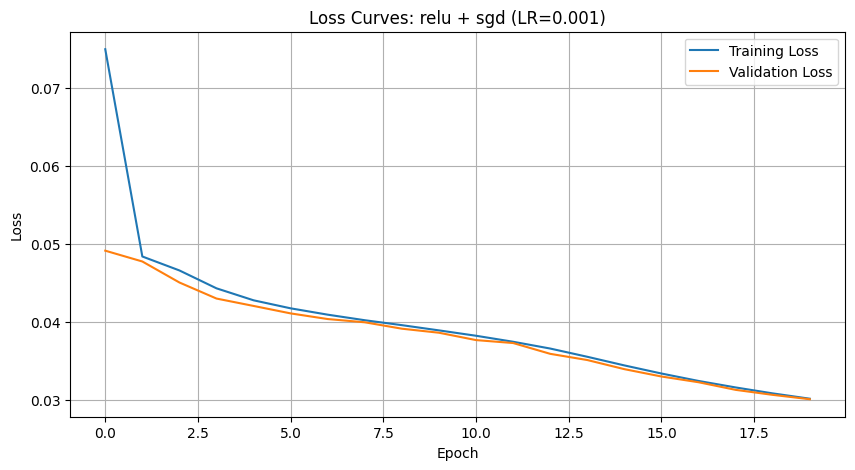

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0379, Val Loss: 0.0377
Epoch 20/30, Train Loss: 0.0295, Val Loss: 0.0294
Epoch 30/30, Train Loss: 0.0248, Val Loss: 0.0254


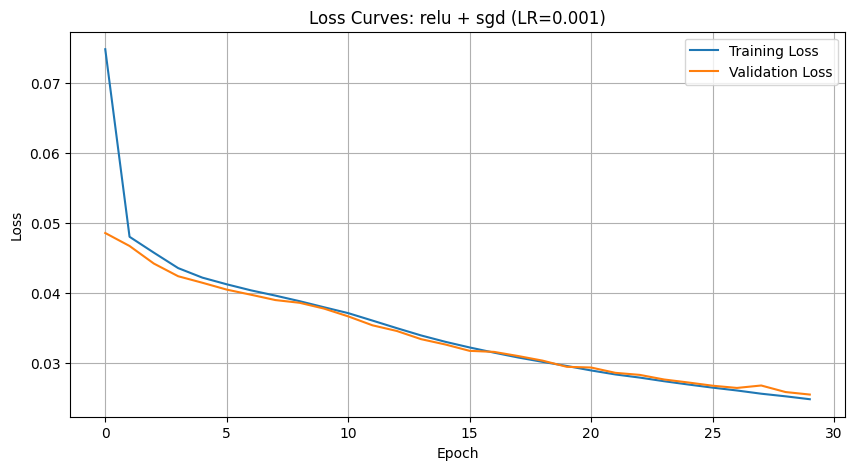

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0248, Val Loss: 0.0243
Epoch 20/20, Train Loss: 0.0167, Val Loss: 0.0180


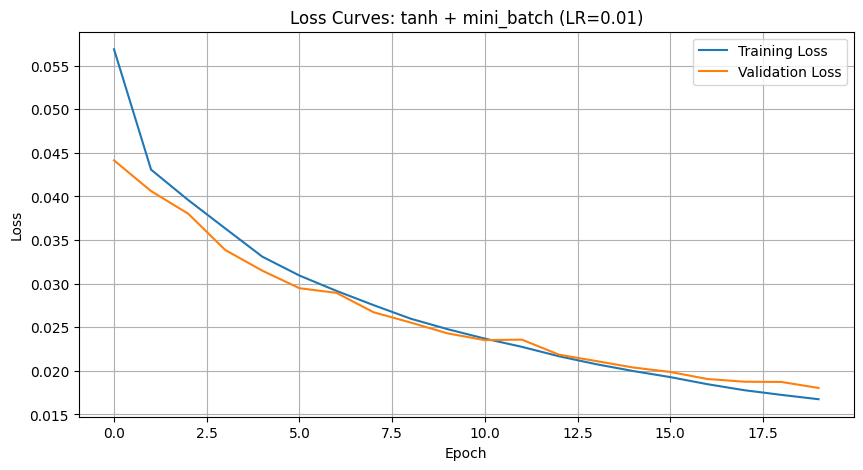

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0248, Val Loss: 0.0245
Epoch 20/30, Train Loss: 0.0166, Val Loss: 0.0176
Epoch 30/30, Train Loss: 0.0124, Val Loss: 0.0151


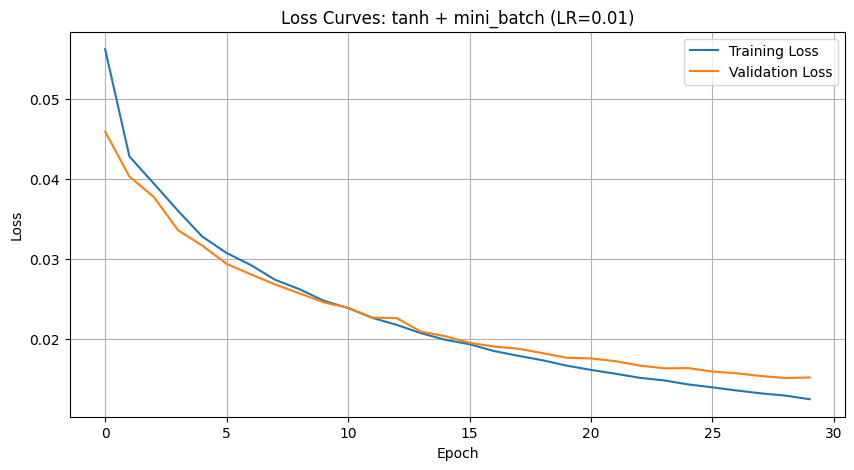

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0183, Val Loss: 0.0175
Epoch 20/20, Train Loss: 0.0102, Val Loss: 0.0230


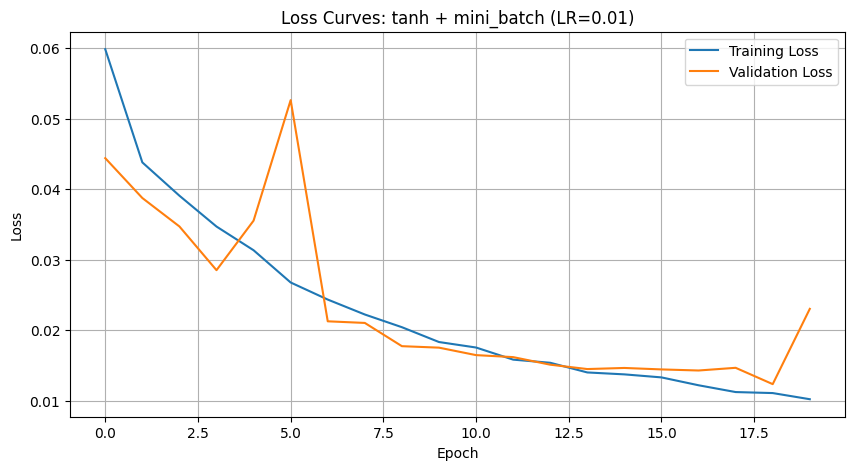

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0184, Val Loss: 0.0181
Epoch 20/30, Train Loss: 0.0104, Val Loss: 0.0152
Epoch 30/30, Train Loss: 0.0068, Val Loss: 0.0116


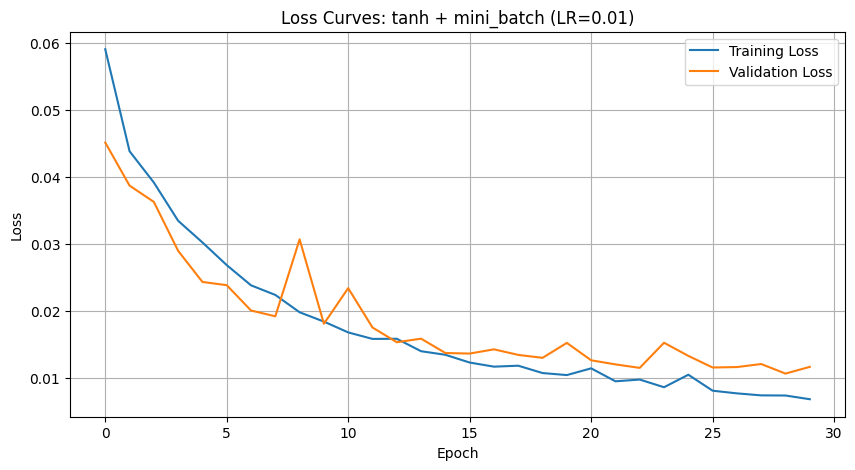

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0437, Val Loss: 0.0433
Epoch 20/20, Train Loss: 0.0402, Val Loss: 0.0400


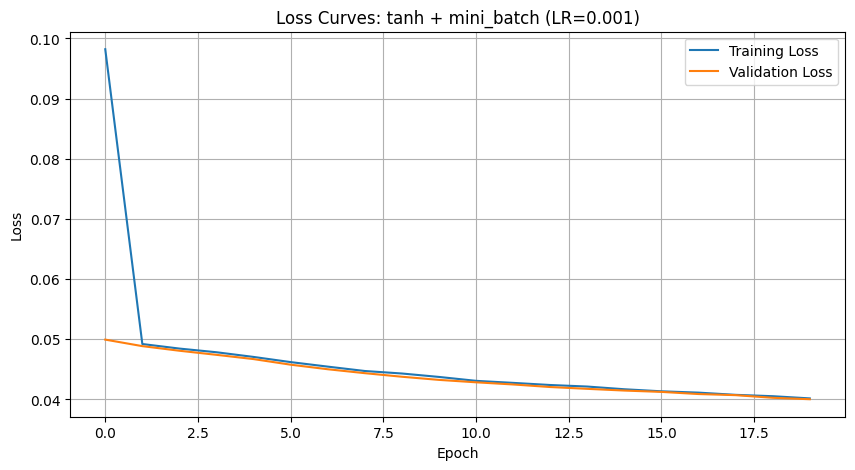

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0435, Val Loss: 0.0432
Epoch 20/30, Train Loss: 0.0400, Val Loss: 0.0399
Epoch 30/30, Train Loss: 0.0367, Val Loss: 0.0366


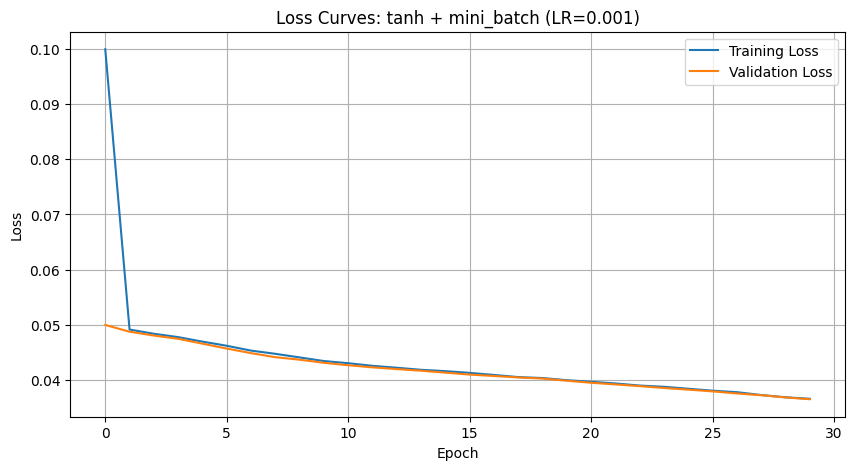

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0419, Val Loss: 0.0414
Epoch 20/20, Train Loss: 0.0366, Val Loss: 0.0366


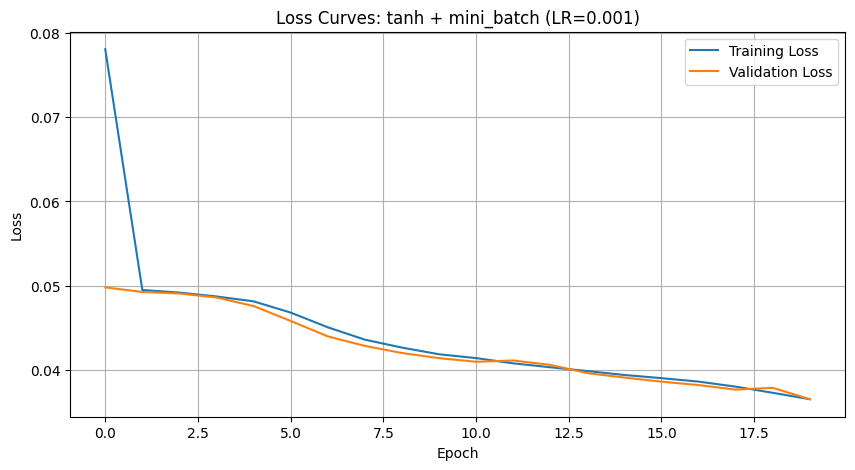

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0414, Val Loss: 0.0410
Epoch 20/30, Train Loss: 0.0357, Val Loss: 0.0352
Epoch 30/30, Train Loss: 0.0299, Val Loss: 0.0306


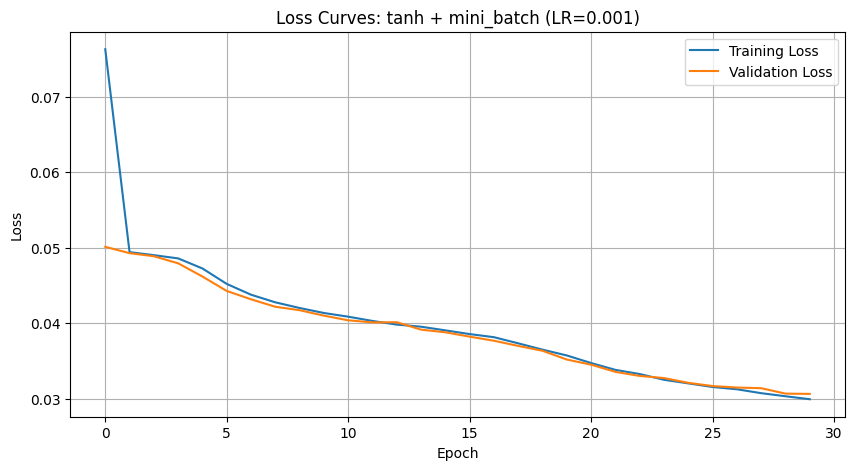

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.4224, Val Loss: 0.4271
Epoch 20/20, Train Loss: 0.4224, Val Loss: 0.4271


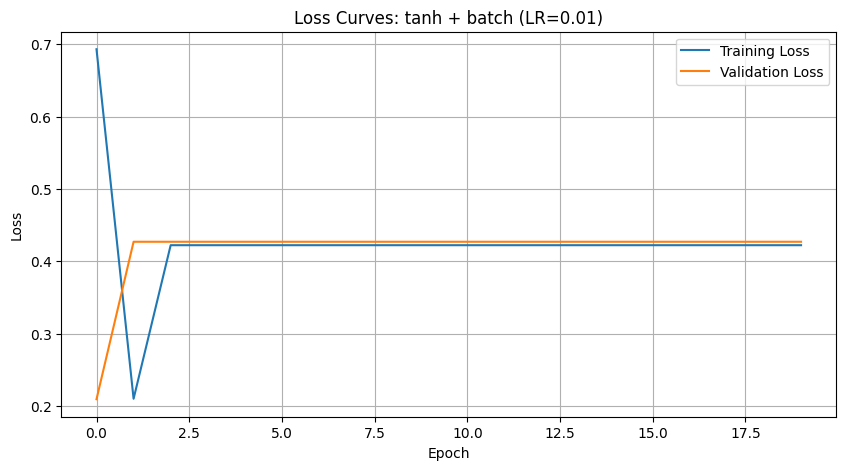

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.4224, Val Loss: 0.4271
Epoch 20/30, Train Loss: 0.4224, Val Loss: 0.4271
Epoch 30/30, Train Loss: 0.6041, Val Loss: 0.6094


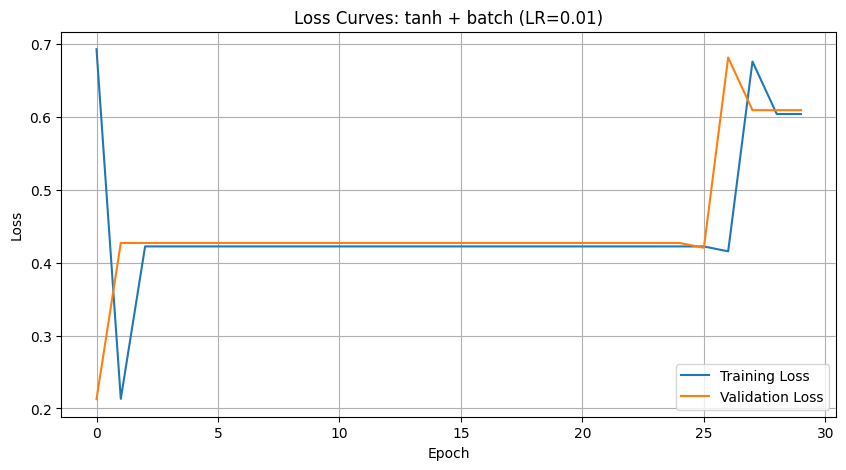

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.4224, Val Loss: 0.4271
Epoch 20/20, Train Loss: 0.4224, Val Loss: 0.4271


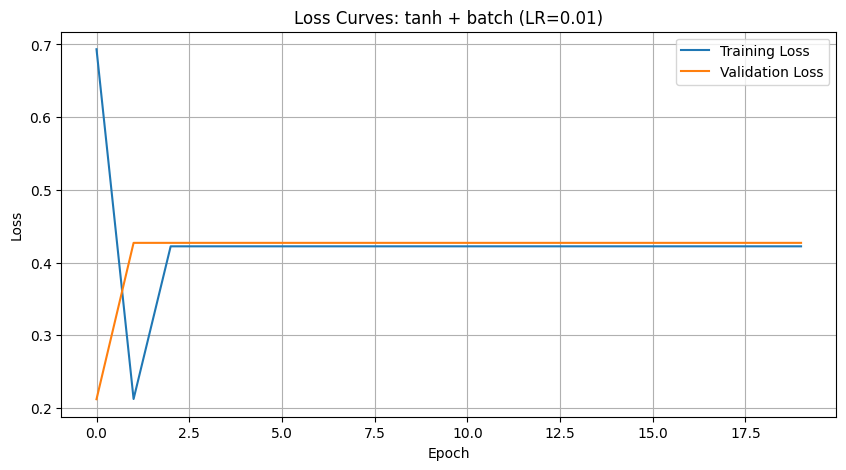

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.4224, Val Loss: 0.4271
Epoch 20/30, Train Loss: 0.4224, Val Loss: 0.4271
Epoch 30/30, Train Loss: 0.4224, Val Loss: 0.4271


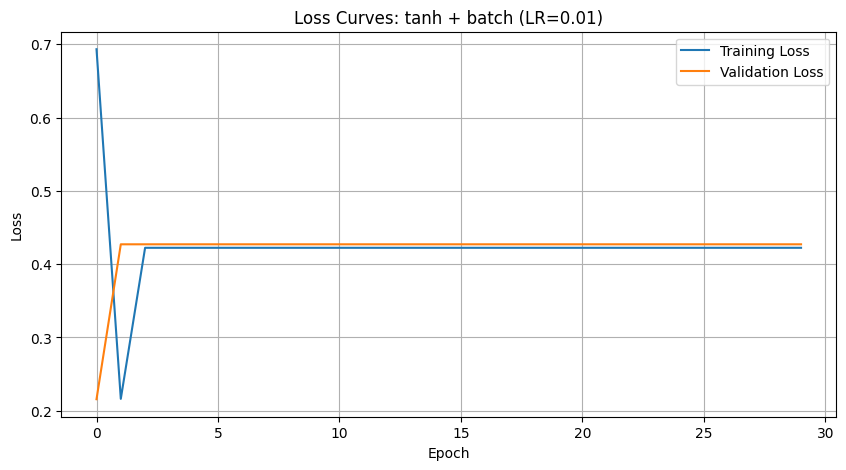

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.3569, Val Loss: 0.3620
Epoch 20/20, Train Loss: 0.3574, Val Loss: 0.3628


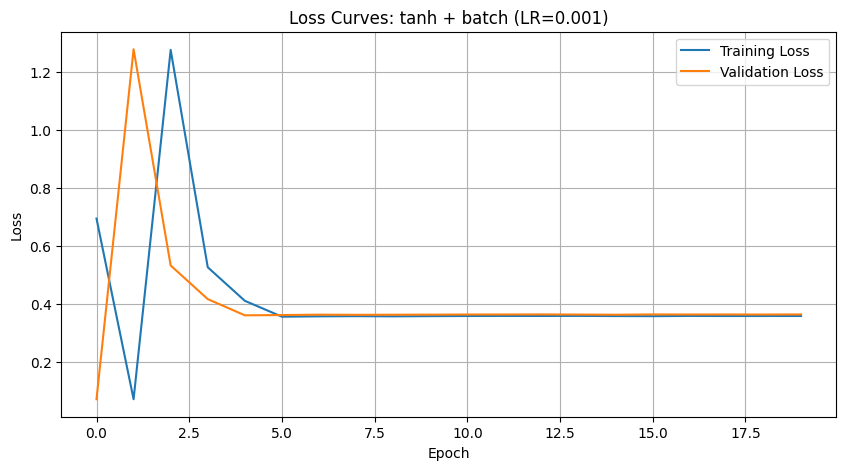

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.4098, Val Loss: 0.4139
Epoch 20/30, Train Loss: 0.4106, Val Loss: 0.4142
Epoch 30/30, Train Loss: 0.4097, Val Loss: 0.4135


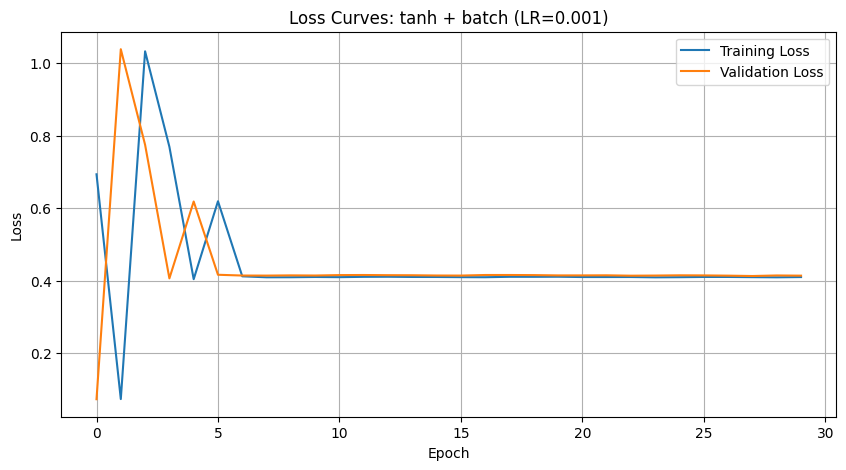

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.2827, Val Loss: 0.2842
Epoch 20/20, Train Loss: 0.2845, Val Loss: 0.2844


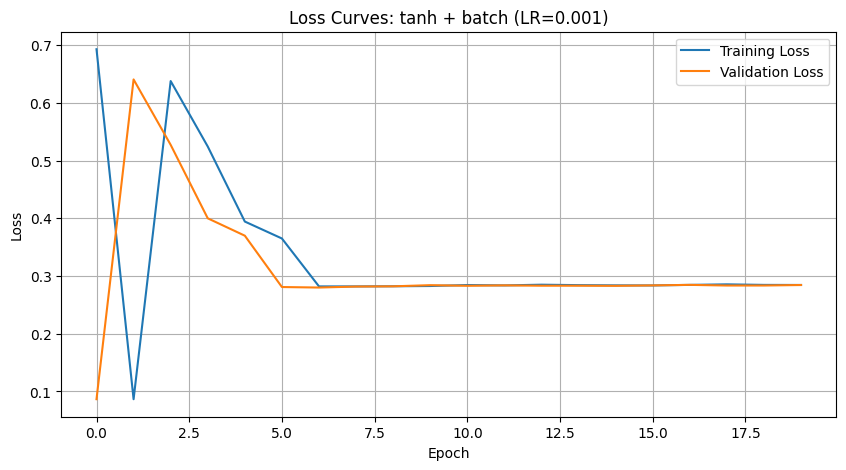

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.4024, Val Loss: 0.4074
Epoch 20/30, Train Loss: 0.4021, Val Loss: 0.4069
Epoch 30/30, Train Loss: 0.4023, Val Loss: 0.4068


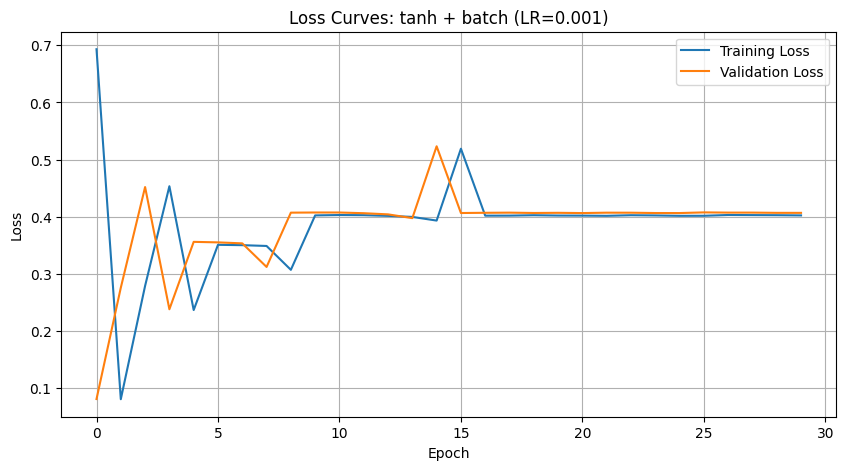

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0247, Val Loss: 0.0246
Epoch 20/20, Train Loss: 0.0166, Val Loss: 0.0178


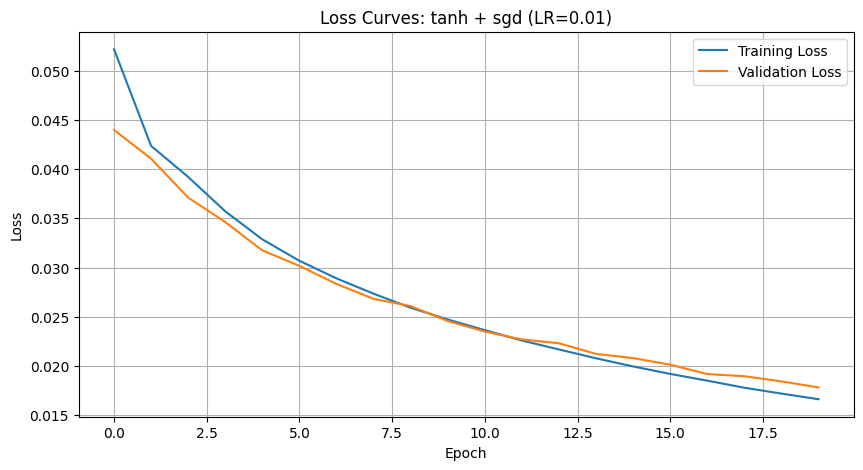

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0247, Val Loss: 0.0245
Epoch 20/30, Train Loss: 0.0166, Val Loss: 0.0177
Epoch 30/30, Train Loss: 0.0124, Val Loss: 0.0150


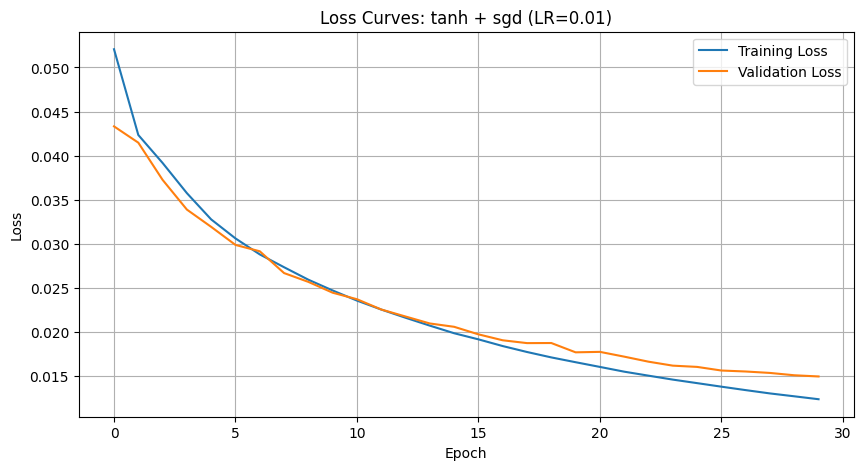

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0155, Val Loss: 0.0166
Epoch 20/20, Train Loss: 0.0084, Val Loss: 0.0142


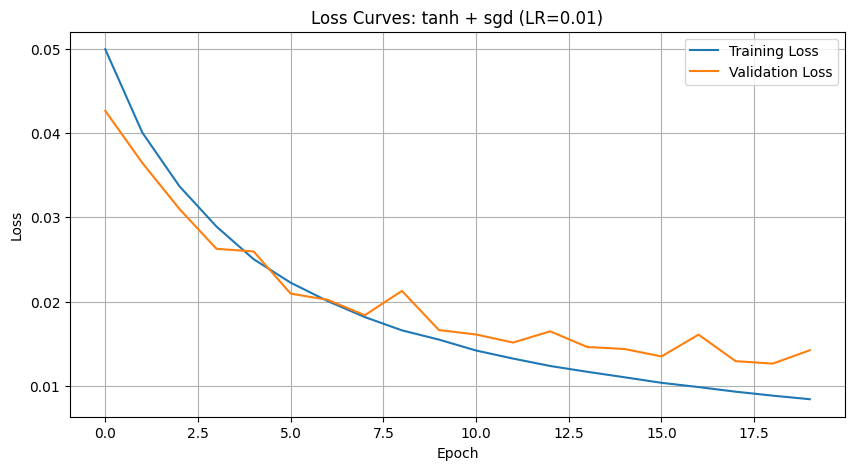

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0162, Val Loss: 0.0185
Epoch 20/30, Train Loss: 0.0088, Val Loss: 0.0134
Epoch 30/30, Train Loss: 0.0055, Val Loss: 0.0109


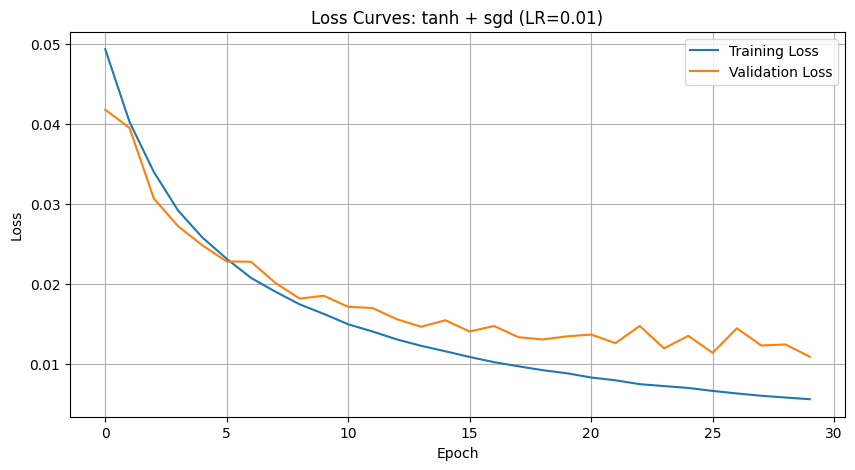

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0435, Val Loss: 0.0431
Epoch 20/20, Train Loss: 0.0400, Val Loss: 0.0397


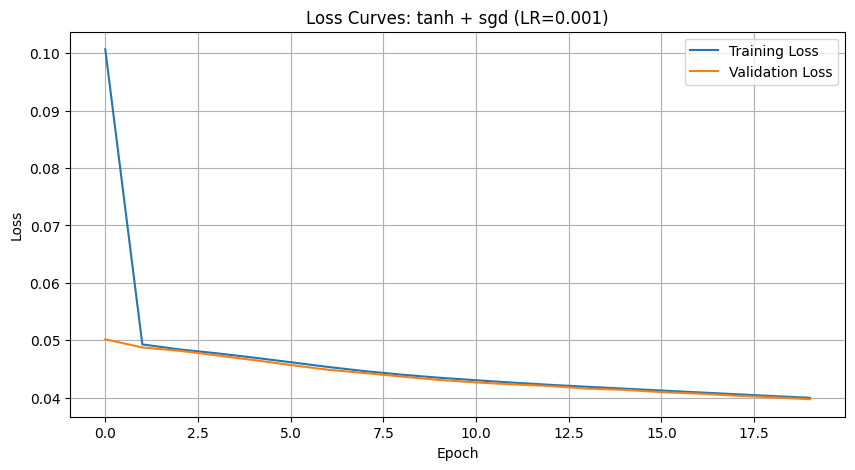

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0437, Val Loss: 0.0433
Epoch 20/30, Train Loss: 0.0401, Val Loss: 0.0399
Epoch 30/30, Train Loss: 0.0367, Val Loss: 0.0366


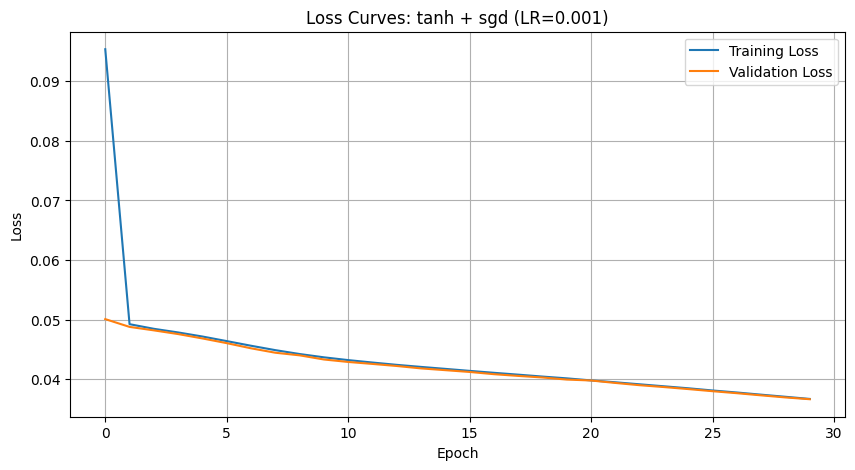

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0413, Val Loss: 0.0409
Epoch 20/20, Train Loss: 0.0339, Val Loss: 0.0338


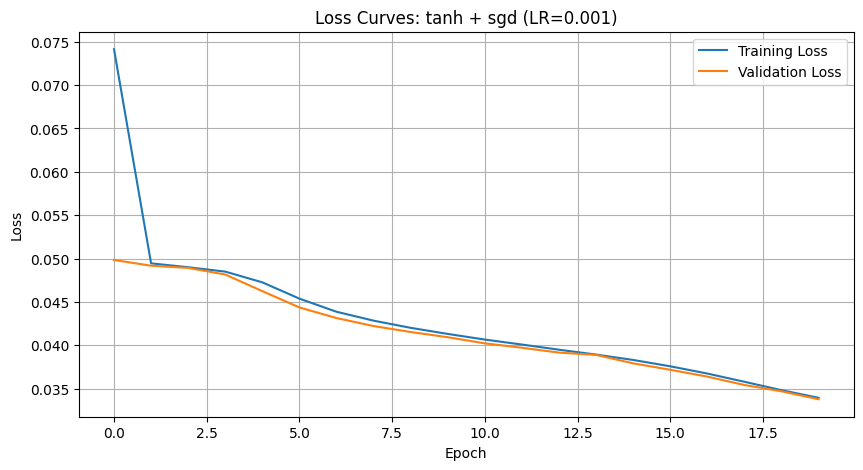

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0411, Val Loss: 0.0410
Epoch 20/30, Train Loss: 0.0342, Val Loss: 0.0343
Epoch 30/30, Train Loss: 0.0285, Val Loss: 0.0291


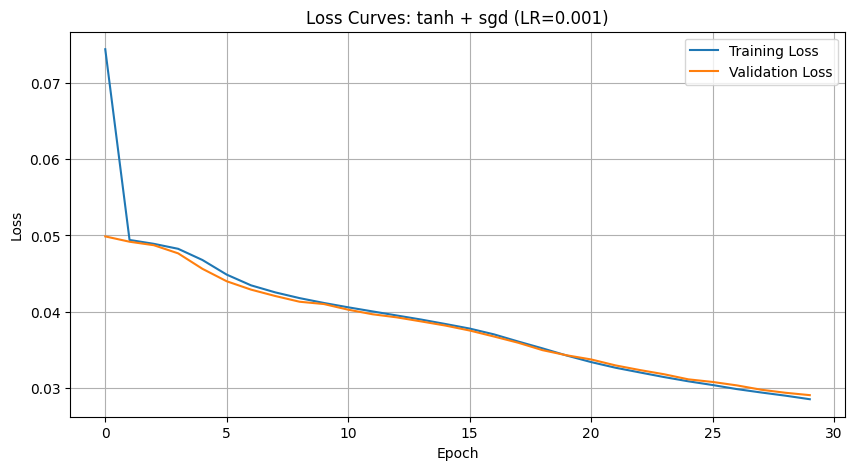

----------------------------------------




In [5]:
results = run_experiments(X_train_cp, y_train_cp, X_val_cp, y_val_cp, X_test_cp, y_test_cp, input_size, output_size)

In [6]:
# Display results
display_results(results)

# Save results to a csv file
results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)


======= RESULTS =======

Rank 1: tanh + mini_batch (LR=0.01)
Architecture: [5000, 128, 64, 90]
Batch Size: 32
Training Time: 12.51 seconds

Test Metrics:
  Hamming Loss: 0.0040
  Accuracy: 0.7926
  Precision: 0.8829
  Recall: 0.8218
  F1 Score: 0.8513

Rank 2: relu + sgd (LR=0.01)
Architecture: [5000, 128, 64, 90]
Batch Size: 32
Training Time: 235.59 seconds

Test Metrics:
  Hamming Loss: 0.0041
  Accuracy: 0.7807
  Precision: 0.8907
  Recall: 0.7991
  F1 Score: 0.8425

Rank 3: relu + mini_batch (LR=0.01)
Architecture: [5000, 128, 64, 90]
Batch Size: 32
Training Time: 13.10 seconds

Test Metrics:
  Hamming Loss: 0.0042
  Accuracy: 0.7797
  Precision: 0.8941
  Recall: 0.7890
  F1 Score: 0.8383

Rank 4: relu + sgd (LR=0.01)
Architecture: [5000, 128, 64, 90]
Batch Size: 32
Training Time: 354.50 seconds

Test Metrics:
  Hamming Loss: 0.0044
  Accuracy: 0.7738
  Precision: 0.8545
  Recall: 0.8160
  F1 Score: 0.8348

Rank 5: tanh + sgd (LR=0.01)
Architecture: [5000, 128, 64, 90]
Batch Size:


Best model based on Hamming Loss:
  Activation: tanh
  Optimizer: mini_batch
  Learning Rate: 0.01
  Architecture: [5000, 128, 64, 90]
  Batch Size: 32
  Test Hamming Loss: 0.0040


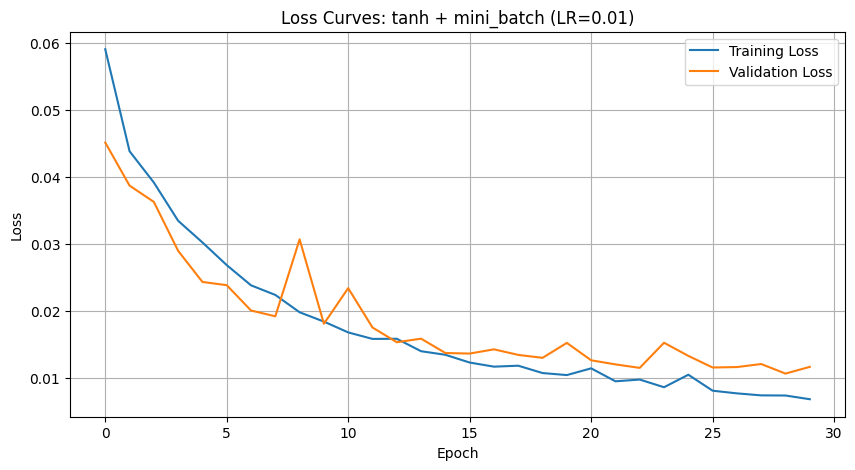


Best model based on Accuracy:
  Activation: tanh
  Optimizer: mini_batch
  Learning Rate: 0.01
  Architecture: [5000, 128, 64, 90]
  Batch Size: 32
  Test Accuracy: 0.7926


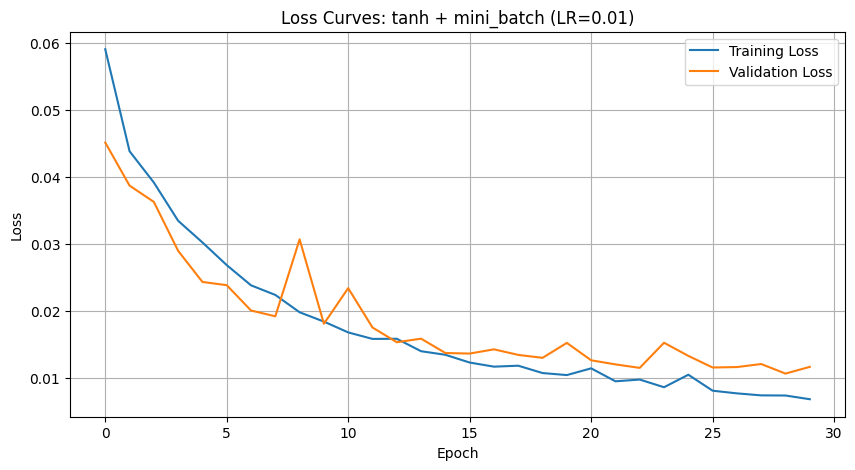

In [7]:
# Find the best model based on Hamming Loss
best_result = min(results, key=lambda x: x['test_metrics']['Hamming Loss'])
print("\nBest model based on Hamming Loss:")
print(f"  Activation: {best_result['activation']}")
print(f"  Optimizer: {best_result['optimizer']}")
print(f"  Learning Rate: {best_result['learning_rate']}")
print(f"  Architecture: {best_result['architecture']}")
print(f"  Batch Size: {best_result['batch_size']}")
print(f"  Test Hamming Loss: {best_result['test_metrics']['Hamming Loss']:.4f}")

# Plot training curves for the best model
plt.figure(figsize=(10, 5))
plt.plot(best_result['train_loss_history'], label='Training Loss')
plt.plot(best_result['val_loss_history'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss Curves: {best_result["activation"]} + {best_result["optimizer"]} (LR={best_result["learning_rate"]})')
plt.legend()
plt.grid(True)
plt.show()

# Find the best model based on Accuracy
best_result = max(results, key=lambda x: x['test_metrics']['Accuracy'])
print("\nBest model based on Accuracy:")
print(f"  Activation: {best_result['activation']}")
print(f"  Optimizer: {best_result['optimizer']}")
print(f"  Learning Rate: {best_result['learning_rate']}")
print(f"  Architecture: {best_result['architecture']}")
print(f"  Batch Size: {best_result['batch_size']}")
print(f"  Test Accuracy: {best_result['test_metrics']['Accuracy']:.4f}")

# Plot training curves for the best model
plt.figure(figsize=(10, 5))
plt.plot(best_result['train_loss_history'], label='Training Loss')
plt.plot(best_result['val_loss_history'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss Curves: {best_result["activation"]} + {best_result["optimizer"]} (LR={best_result["learning_rate"]})')
plt.legend()
plt.grid(True)
plt.show()
